In [ ]:
import pandas as pd
import re

# Load the dataset
file_path = "/content/soildataset.xlsx - Sheet1.csv"
df = pd.read_csv(file_path)

# Extract common prefix by removing the last number (1-10) from "Records" column
df["Records_Group"] = df["Records"].apply(lambda x: re.sub(r"[-_]\d+$", "", str(x)))

# Convert numeric columns to proper data types (ignoring non-numeric ones)
numeric_cols = df.select_dtypes(include=["number"]).columns
df_mean = df.groupby("Records_Group")[numeric_cols].mean().reset_index()

# Save the updated file in CSV format
output_path = "Usoildataset.csv"
df_mean.to_csv(output_path, index=False)

print(f"Updated dataset saved to: {output_path}")


Updated dataset saved to: Usoildataset.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

# Load and clean data
df = pd.read_csv('Usoildataset.csv')
df_clean = df.dropna(subset=['Ph'])

wavelengths = ['410', '435', '460', '485', '510', '535', '560', '585', '610',
               '645', '680', '705', '730', '760', '810', '860', '900', '940']

# Compute first derivative (sequential differences)
df_deriv = df_clean[wavelengths].diff(axis=1).drop(columns=['410'])  # Drop first NaN column
derivative_wavelengths = wavelengths[1:]  # New wavelengths after differencing

# Smooth the derivative (optional, reduces noise)
df_deriv_smoothed = pd.DataFrame(
    savgol_filter(df_deriv, window_length=5, polyorder=2, axis=1),
    columns=derivative_wavelengths
)

# Compute correlation with pH
corr_with_ph = df_deriv_smoothed.corrwith(df_clean['Ph']).abs().sort_values(ascending=False)

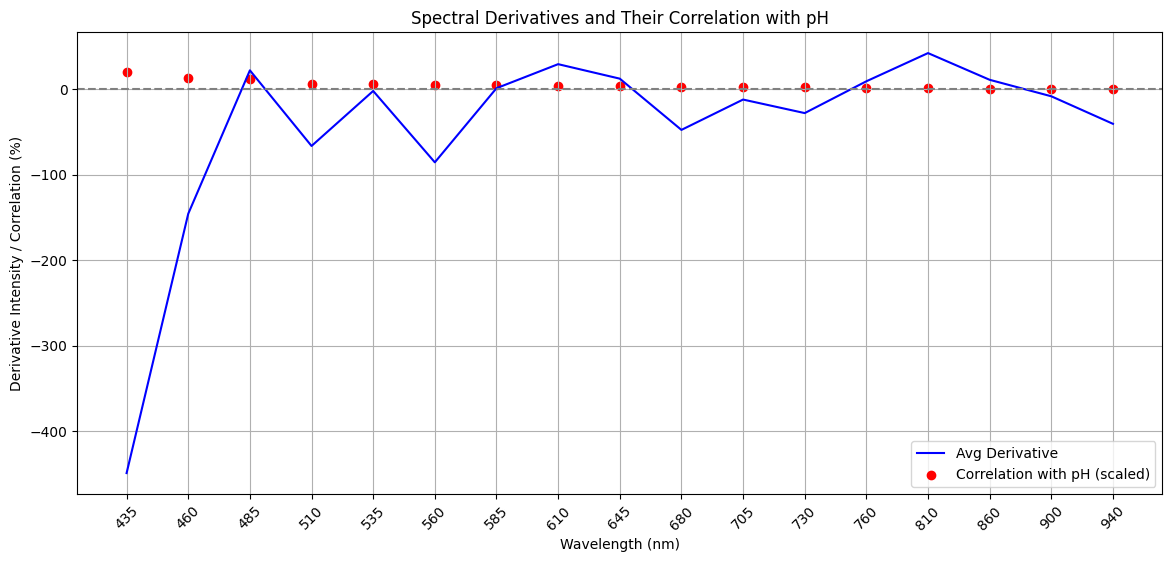

In [ ]:
# Plot derivative trends
plt.figure(figsize=(14, 6))
plt.plot(derivative_wavelengths, df_deriv_smoothed.mean(), 'b-', label='Avg Derivative')
plt.scatter(derivative_wavelengths, corr_with_ph * 100, c='red', label='Correlation with pH (scaled)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Spectral Derivatives and Their Correlation with pH")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Derivative Intensity / Correlation (%)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate correlations between derivatives and pH
corr_with_ph = df_deriv_smoothed.corrwith(df_clean['Ph']).abs()

# Debugging output
print("All wavelength correlations with pH:")
print(corr_with_ph.sort_values(ascending=False))

# Set threshold based on actual data spread
threshold = corr_with_ph.quantile(0.75)  # Use top 25% of correlations
print("\nUsing adaptive threshold:", threshold)

# Get key wavelengths
key_wavelengths = corr_with_ph[corr_with_ph > threshold].index.tolist()

print("\nKey wavelengths affecting pH:")
if key_wavelengths:
    for w in key_wavelengths:
        print(f"{w}nm (r={corr_with_ph[w]:.2f})")
else:
    print("No wavelengths exceeded the threshold. Try lowering the threshold value.")

All wavelength correlations with pH:
485    0.201204
510    0.127684
535    0.111917
760    0.059841
705    0.055841
460    0.050605
810    0.045491
860    0.038810
940    0.032661
610    0.025692
900    0.024004
435    0.018428
560    0.014703
680    0.006253
585    0.003544
730    0.002557
645    0.001110
dtype: float64

Using adaptive threshold: 0.05584100400894387

Key wavelengths affecting pH:
485nm (r=0.20)
510nm (r=0.13)
535nm (r=0.11)
760nm (r=0.06)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load and clean data
df = pd.read_csv('Usoildataset.csv').dropna()

# Improved function to extract water level
def extract_water_level(record_group):
    # Handle cases like '100_25ml' or '100-25ml'
    if '_' in record_group:
        parts = record_group.split('_')
    elif '-' in record_group and 'ml' in record_group:
        parts = record_group.split('-')
    else:
        return np.nan

    # Find the part that contains 'ml'
    for part in parts:
        if 'ml' in part:
            return part
    return np.nan

# Apply the function to create water_level column
df['water_level'] = df['Records_Group'].apply(extract_water_level)

# Drop rows where water_level couldn't be extracted
df = df.dropna(subset=['water_level'])

# Convert all water levels to consistent format (e.g., '25ml')
df['water_level'] = df['water_level'].str.extract(r'(\d+ml)')[0]

# Now group only by water_level (not including Records_Group)
grouped_df = df.groupby('water_level').mean(numeric_only=True).reset_index()

# Verify we have numeric data
print("Data types after grouping:")
print(grouped_df.dtypes)

# Select features and targets
wavelengths = ['485', '510', '535', '760']
targets = ['Ph', 'Nitro (mg/10 g)', 'Posh Nitro (mg/10 g)', 'Pota Nitro (mg/10 g)',
           'Temp', 'Moist', 'EC (u/10 gram)']

# Prepare data - ensure we only use numeric columns
X = grouped_df[wavelengths]
y = grouped_df[targets]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
models = {}
results = {}
for target in targets:
    model = RandomForestRegressor(n_estimators=150, random_state=42)
    model.fit(X_train_scaled, y_train[target])

    y_pred = model.predict(X_test_scaled)
    results[target] = {
        'R2': r2_score(y_test[target], y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test[target], y_pred))
    }
    models[target] = model

# Display results
print("\nWater Level Groups Created:")
print(grouped_df['water_level'].unique())
print("\nModel Performance:")
for target, metrics in results.items():
    print(f"{target}: R²={metrics['R2']:.3f}, RMSE={metrics['RMSE']:.3f}")

# Show sample predictions
print("\nSample Prediction (using first test sample):")
sample = X_test.iloc[0:1]
sample_scaled = scaler.transform(sample)
for target in targets:
    pred = models[target].predict(sample_scaled)[0]
    print(f"{target}: {pred:.3f} (Actual: {y_test[target].iloc[0]:.3f})")

Data types after grouping:
water_level              object
410                     float64
435                     float64
460                     float64
485                     float64
510                     float64
535                     float64
560                     float64
585                     float64
610                     float64
645                     float64
680                     float64
705                     float64
730                     float64
760                     float64
810                     float64
860                     float64
900                     float64
940                     float64
Capacitity Moist        float64
Temp                    float64
Moist                   float64
EC (u/10 gram)          float64
Ph                      float64
Nitro (mg/10 g)         float64
Posh Nitro (mg/10 g)    float64
Pota Nitro (mg/10 g)    float64
dtype: object

Water Level Groups Created:
['0ml' '25ml' '50ml' '75ml']

Model Performance:
Ph: R²=-1.082, RM

Training models with small dataset...


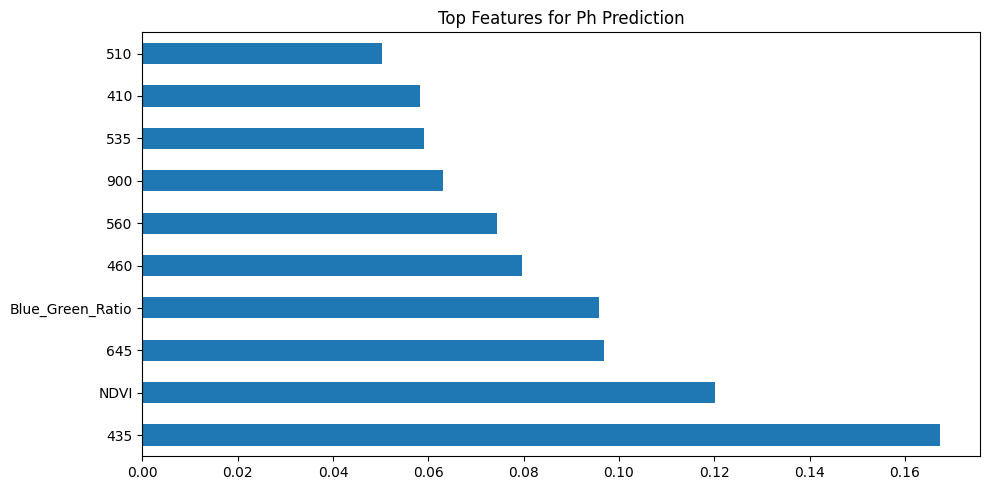

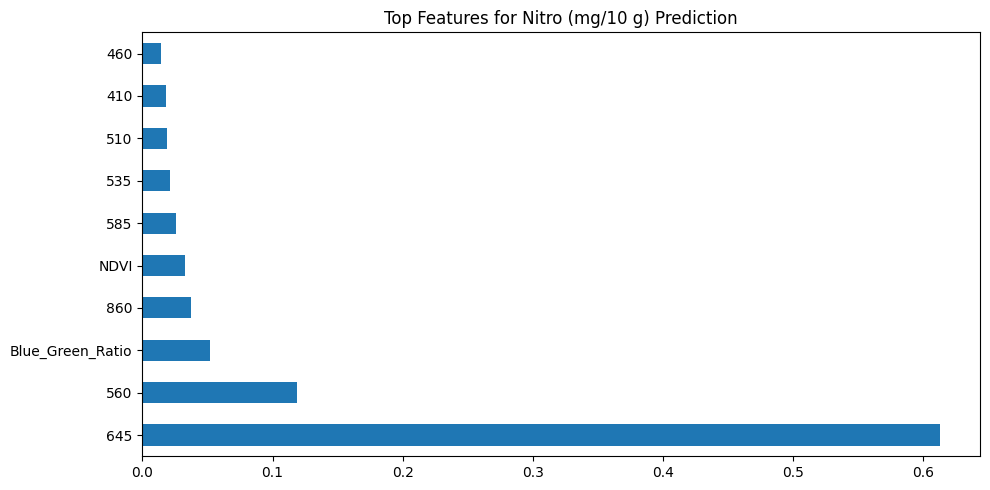

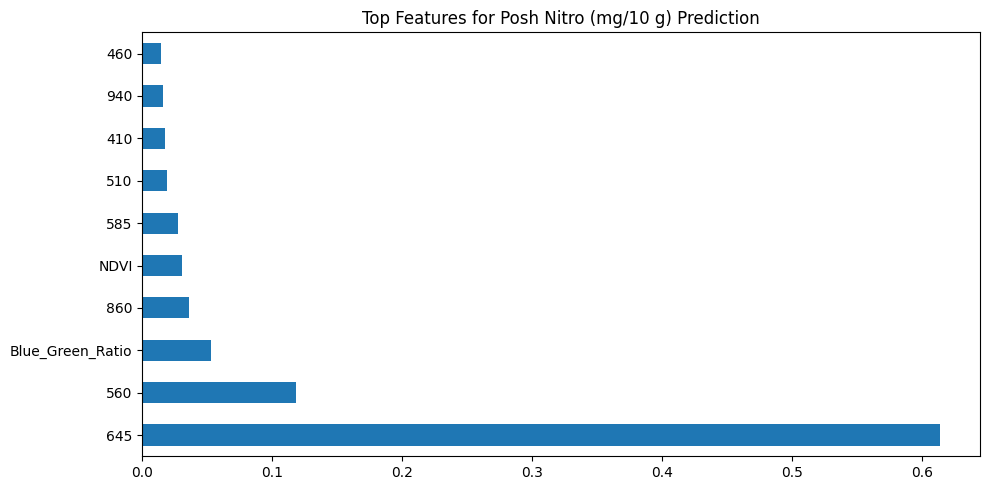

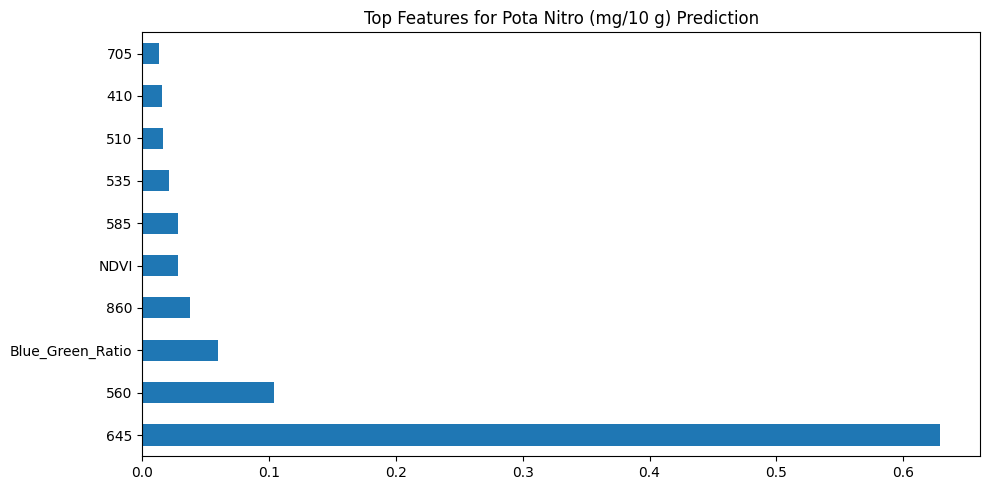

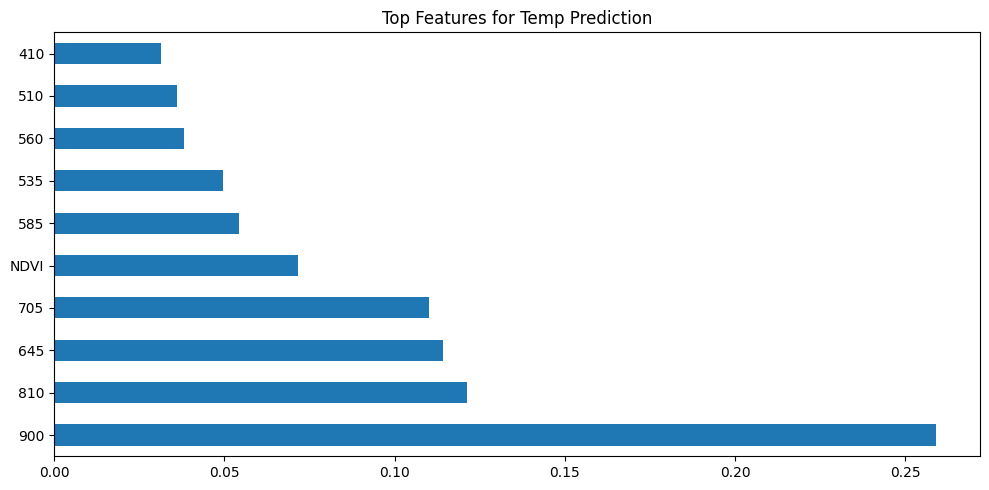

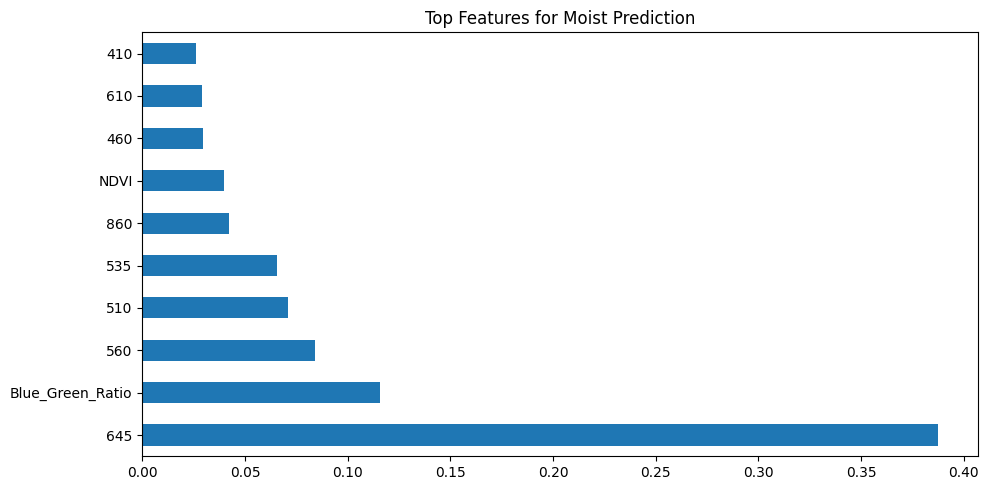

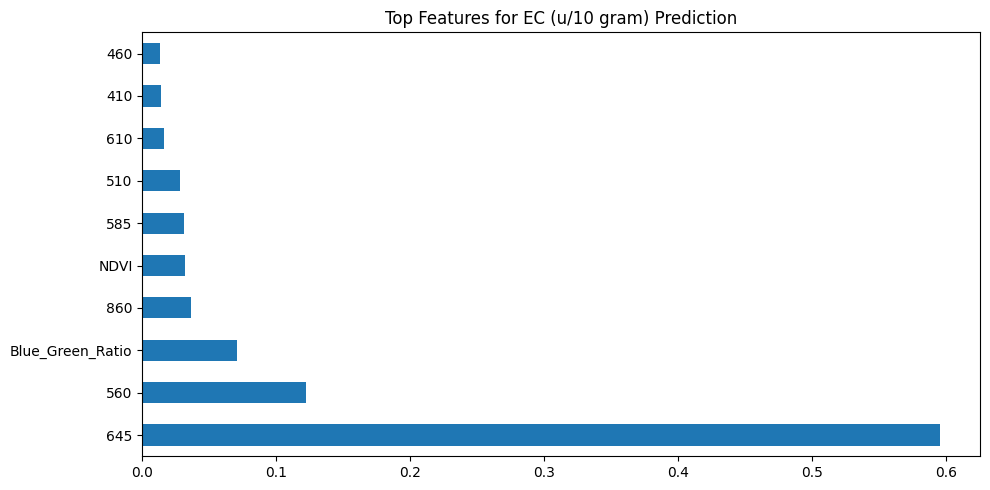


Model Performance (MAE on full dataset):
Ph: MAE = 0.2077
Nitro (mg/10 g): MAE = 0.0232
Posh Nitro (mg/10 g): MAE = 0.0324
Pota Nitro (mg/10 g): MAE = 0.0812
Temp: MAE = 0.9614
Moist: MAE = 4.8186
EC (u/10 gram): MAE = 0.3735

Sample Predictions:
Ph: Predicted 7.494 | Actual 7.777 | Error 3.6%
Nitro (mg/10 g): Predicted 0.080 | Actual 0.000 | Error 0.0%
Posh Nitro (mg/10 g): Predicted 0.113 | Actual 0.000 | Error 0.0%
Pota Nitro (mg/10 g): Predicted 0.292 | Actual 0.000 | Error 0.0%
Temp: Predicted 37.221 | Actual 37.150 | Error 0.2%
Moist: Predicted 9.642 | Actual 0.000 | Error 0.0%
EC (u/10 gram): Predicted 1.090 | Actual 0.000 | Error 0.0%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Load and clean data
df = pd.read_csv('/content/Usoildataset.csv').dropna()
wavelengths = ['410', '435', '460', '485', '510', '535', '560', '585', '610',
               '645', '680', '705', '730', '760', '810', '860', '900', '940']
targets = ['Ph', 'Nitro (mg/10 g)', 'Posh Nitro (mg/10 g)', 'Pota Nitro (mg/10 g)',
           'Temp', 'Moist', 'EC (u/10 gram)']

# Simplified feature engineering
X = df[wavelengths].copy()
X['NDVI'] = (X['860'] - X['680']) / (X['860'] + X['680'] + 1e-6)
X['Blue_Green_Ratio'] = X['460'] / (X['510'] + 1e-6)
y = df[targets]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train simple models without CV
models = {}
results = {}

print("Training models with small dataset...")
for target in targets:
    # Simple Random Forest with fixed parameters
    model = RandomForestRegressor(
        n_estimators=50,
        max_depth=3,
        random_state=42
    )
    model.fit(X_scaled, y[target])
    models[target] = model

    # Get predictions
    y_pred = model.predict(X_scaled)
    mae = mean_absolute_error(y[target], y_pred)
    results[target] = {'MAE': mae}

    # Plot feature importance
    plt.figure(figsize=(10, 5))
    importances = pd.Series(model.feature_importances_, index=X.columns)
    importances.nlargest(10).plot(kind='barh')
    plt.title(f'Top Features for {target} Prediction')
    plt.tight_layout()
    plt.show()

# Show simple results
print("\nModel Performance (MAE on full dataset):")
for target, res in results.items():
    print(f"{target}: MAE = {res['MAE']:.4f}")

# Sample predictions
print("\nSample Predictions:")
sample_idx = 0
sample = X_scaled[sample_idx].reshape(1, -1)
for target in targets:
    pred = models[target].predict(sample)[0]
    actual = y[target].iloc[sample_idx]
    error = abs(pred - actual) / actual * 100 if actual != 0 else 0
    print(f"{target}: Predicted {pred:.3f} | Actual {actual:.3f} | Error {error:.1f}%")

Initial Data Exploration:
Original dataset shape: (165, 27)

First 5 rows:
  Records_Group       410       435       460       485       510       535  \
0       100_0ml  717.8885  146.2555  366.1325   95.2335  173.9600  162.6580   
1      100_25ml  676.7670  131.0900  326.0500   86.4090  151.4475  146.3760   
2      100_50ml  685.4220  134.6780  334.2565   85.2275  153.2130  144.0955   
3       101_0ml  769.9390  163.9080  411.0630  104.7750  204.1550  182.6540   
4      101_25ml  717.8500  145.2480  356.4710   95.0640  173.0600  157.8870   

       560      585       610  ...      900    940  Capacitity Moist   Temp  \
0  26.0825  31.7425  141.4690  ...  14.0295  6.772           2644.75  37.15   
1  21.5670  25.0125   99.3975  ...  11.8100  6.200           2480.10  37.15   
2  22.5920  24.8110   93.2150  ...  11.5200  6.155           2299.05  37.19   
3  34.4690  41.7680  180.5360  ...  17.2800  7.258           2650.30  38.50   
4  25.1670  29.6140  127.9460  ...  13.8300  6.288     

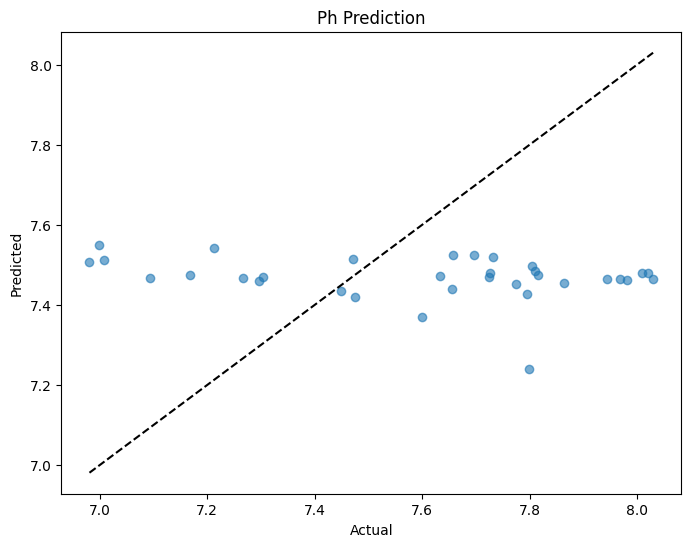

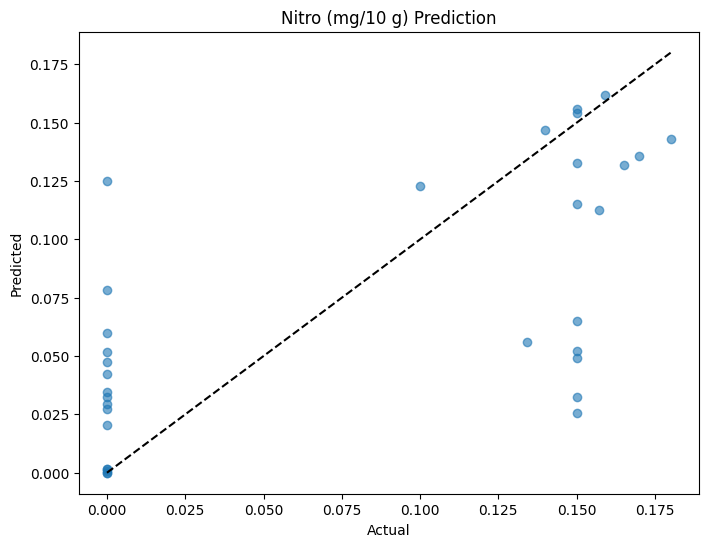

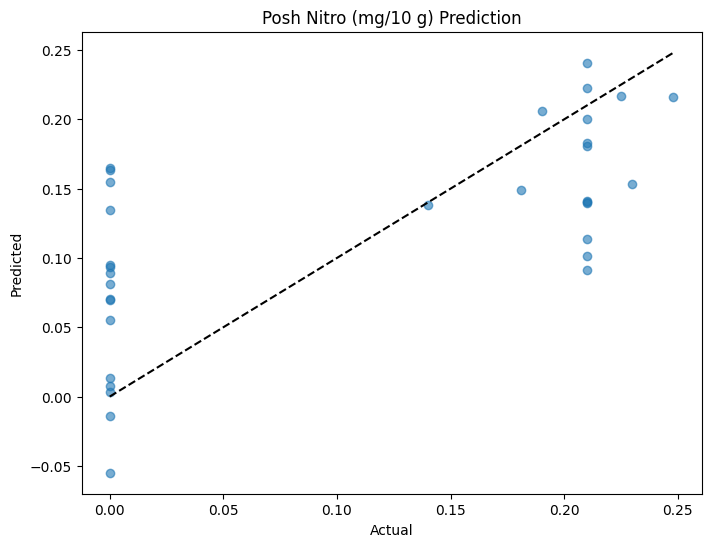

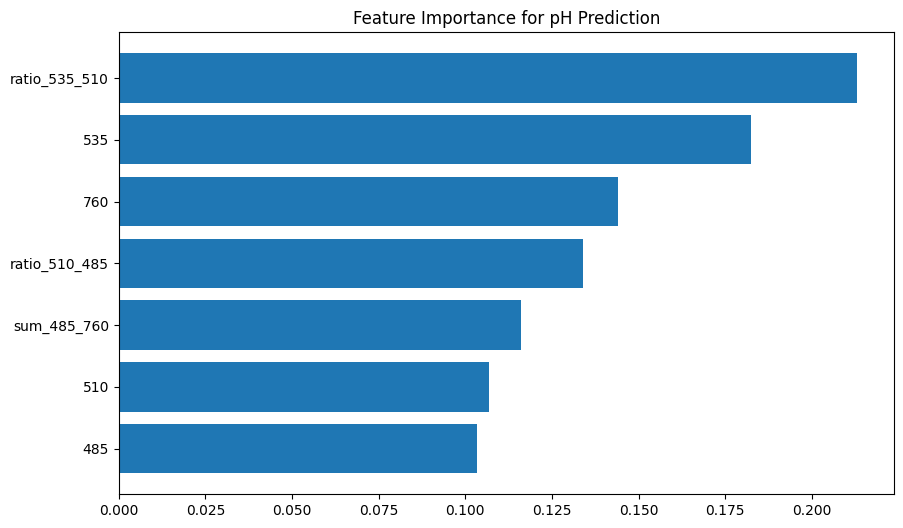


Example Prediction:
Ph: 0.346
Nitro (mg/10 g): 0.550
Posh Nitro (mg/10 g): 0.346
Pota Nitro (mg/10 g): 0.346
Temp: 0.550
Moist: 0.550
EC (u/10 gram): 0.550


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load and clean data
df = pd.read_csv('/content/Usoildataset.csv').dropna()

# 1. Data Exploration
print("Initial Data Exploration:")
print(f"Original dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)

# 2. Feature Engineering
# Extract water level if needed (but we'll use raw data first)
wavelengths = ['485', '510', '535', '760']
targets = ['Ph', 'Nitro (mg/10 g)', 'Posh Nitro (mg/10 g)',
           'Pota Nitro (mg/10 g)', 'Temp', 'Moist', 'EC (u/10 gram)']

# Add ratio features
df['ratio_510_485'] = df['510'] / df['485']
df['ratio_535_510'] = df['535'] / df['510']
df['sum_485_760'] = df['485'] + df['760']
features = wavelengths + ['ratio_510_485', 'ratio_535_510', 'sum_485_760']

# 3. Prepare Data
X = df[features]
y = df[targets]

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Modeling Approach
models = {
    'RandomForest': make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200, random_state=42)),
    'Ridge': make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    'XGBoost': make_pipeline(StandardScaler(), XGBRegressor(n_estimators=100, random_state=42))
}

# 6. Evaluation Function
def evaluate_model(model, X_train, y_train, X_test, y_test, target_name):
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Full training
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        'CV R2 Mean': np.mean(cv_scores),
        'CV R2 Std': np.std(cv_scores),
        'Test R2': r2_score(y_test, y_pred),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }

# 7. Train and Evaluate for Each Target
results = {}
for target in targets:
    print(f"\n=== Modeling for {target} ===")
    target_results = {}

    for name, model in models.items():
        scores = evaluate_model(model, X_train, y_train[target], X_test, y_test[target], target)
        target_results[name] = scores
        print(f"{name}:")
        print(f"  CV R2: {scores['CV R2 Mean']:.3f} ± {scores['CV R2 Std']:.3f}")
        print(f"  Test R2: {scores['Test R2']:.3f}")
        print(f"  Test RMSE: {scores['Test RMSE']:.3f}")

    results[target] = target_results

# 8. Visualization
def plot_predictions(y_true, y_pred, target_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{target_name} Prediction')
    plt.show()

for target in targets[:3]:  # Plot first 3 targets
    best_model_name = max(results[target].items(), key=lambda x: x[1]['Test R2'])[0]
    best_model = models[best_model_name]
    best_model.fit(X_train, y_train[target])
    y_pred = best_model.predict(X_test)
    plot_predictions(y_test[target], y_pred, target)

# 9. Feature Importance (for RandomForest)
rf_model = models['RandomForest'].steps[1][1]
rf_model.fit(X_train, y_train['Ph'])  # Example for pH

plt.figure(figsize=(10, 6))
importances = rf_model.feature_importances_
sorted_idx = importances.argsort()
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance for pH Prediction")
plt.show()

# 10. Final Model Selection and Prediction
final_models = {}
for target in targets:
    # Select best model for each target
    best_model_name = max(results[target].items(), key=lambda x: x[1]['Test R2'])[0]
    final_models[target] = models[best_model_name]
    final_models[target].fit(X_train, y_train[target])

# Example prediction
sample_data = pd.DataFrame({
    '485': [95.23],
    '510': [173.96],
    '535': [162.66],
    '760': [16.47],
    'ratio_510_485': [173.96/95.23],
    'ratio_535_510': [162.66/173.96],
    'sum_485_760': [95.23+16.47]
})

print("\nExample Prediction:")
for target in targets:
    pred = final_models[target].predict(sample_data)[0]
    print(f"{target}: {pred:.3f}")

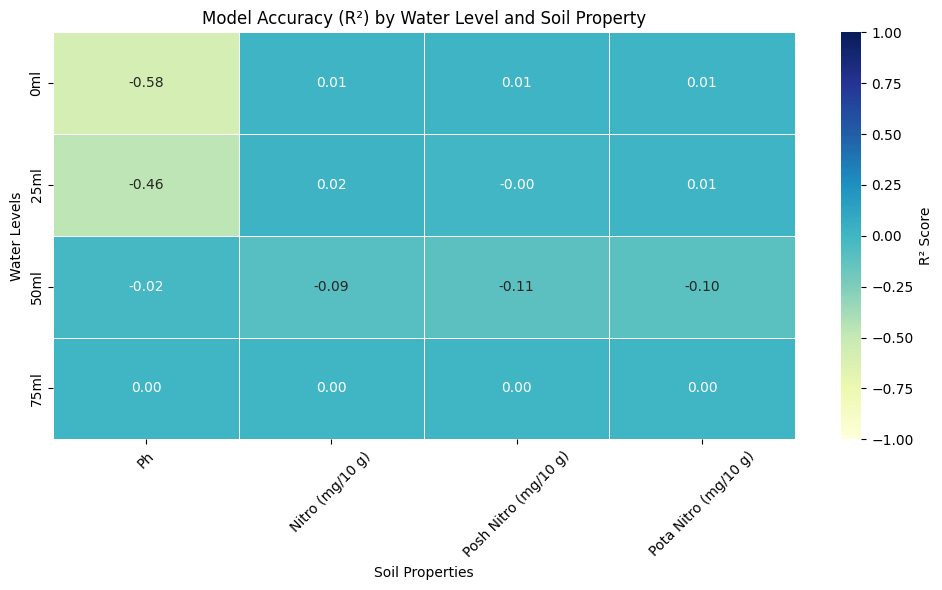


Accuracy Matrix (R² Scores):
            Ph  Nitro (mg/10 g)  Posh Nitro (mg/10 g)  Pota Nitro (mg/10 g)
0ml  -0.583505         0.011211              0.012204              0.013383
25ml -0.463440         0.018222             -0.002599              0.007899
50ml -0.017141        -0.093670             -0.113329             -0.102350
75ml  0.000000         0.000000              0.000000              0.000000

Mean Accuracy by Water Level:
0ml    -0.136677
25ml   -0.109979
50ml   -0.081622
75ml    0.000000
dtype: float64

Mean Accuracy by Soil Property:
Ph                     -0.266021
Nitro (mg/10 g)        -0.016059
Posh Nitro (mg/10 g)   -0.025931
Pota Nitro (mg/10 g)   -0.020267
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Load and clean data
df = pd.read_csv('Usoildataset.csv').dropna()

# Extract water levels
def extract_water_level(record_group):
    if '_' in record_group:
        return record_group.split('_')[-1]
    return np.nan

df['water_level'] = df['Records_Group'].apply(extract_water_level)
df = df.dropna(subset=['water_level'])

# Filter for specific water levels
water_levels = ['0ml', '25ml', '50ml', '75ml']
df = df[df['water_level'].isin(water_levels)]

# Select features and targets
wavelengths = ['485', '510', '535', '760']
targets = ['Ph', 'Nitro (mg/10 g)', 'Posh Nitro (mg/10 g)', 'Pota Nitro (mg/10 g)']

# Create results matrix
results_matrix = pd.DataFrame(index=water_levels, columns=targets)

# Train models and populate matrix
for level in water_levels:
    level_data = df[df['water_level'] == level]
    if len(level_data) < 5:  # Skip if not enough samples
        continue

    X = level_data[wavelengths]
    y = level_data[targets]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for target in targets:
        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train[target])

        # Evaluate
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test[target], y_pred)

        # Store result
        results_matrix.loc[level, target] = r2

# Convert to numeric and fill NA
results_matrix = results_matrix.apply(pd.to_numeric)
results_matrix = results_matrix.fillna(0)  # Replace NA with 0 (no data)

# Create visualization
plt.figure(figsize=(10, 6))
sns.heatmap(results_matrix,
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            vmin=-1,
            vmax=1,
            center=0,
            linewidths=.5,
            cbar_kws={'label': 'R² Score'})

plt.title('Model Accuracy (R²) by Water Level and Soil Property')
plt.xlabel('Soil Properties')
plt.ylabel('Water Levels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display numerical results
print("\nAccuracy Matrix (R² Scores):")
print(results_matrix)

# Calculate mean accuracy for each water level
print("\nMean Accuracy by Water Level:")
print(results_matrix.mean(axis=1))

# Calculate mean accuracy for each soil property
print("\nMean Accuracy by Soil Property:")
print(results_matrix.mean(axis=0))


Training for 0ml - Ph


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


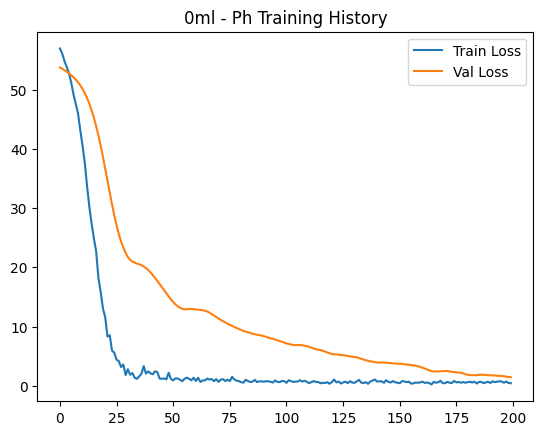


Training for 0ml - Nitro (mg/10 g)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


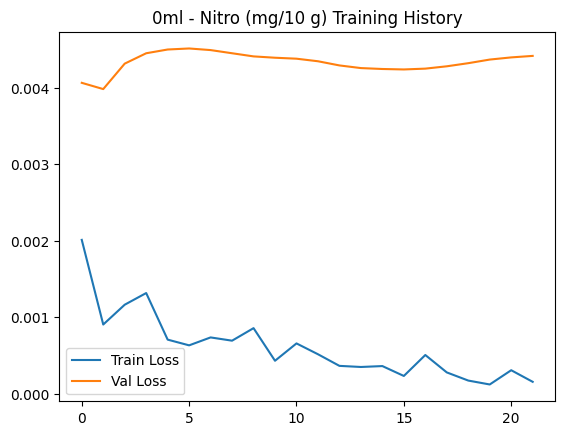


Training for 0ml - Posh Nitro (mg/10 g)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


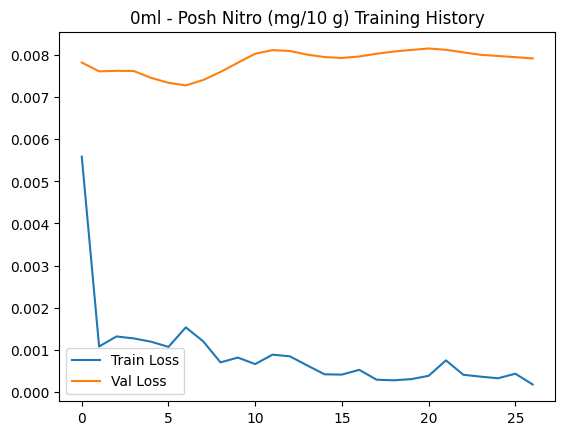


Training for 0ml - Pota Nitro (mg/10 g)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


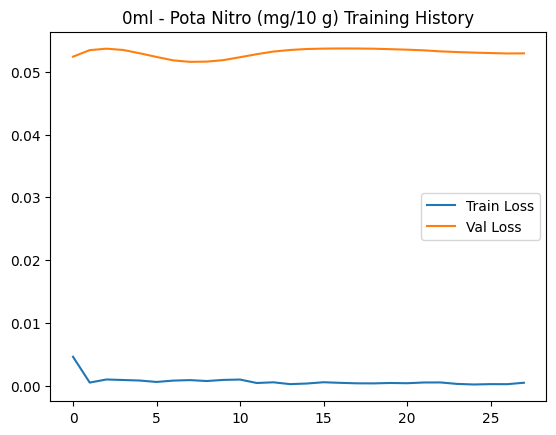


Training for 25ml - Ph


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


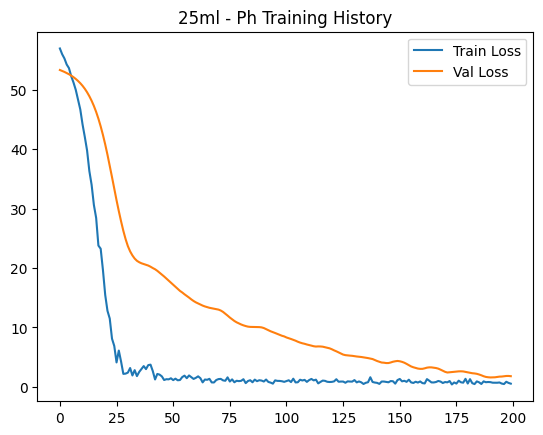

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training for 25ml - Nitro (mg/10 g)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


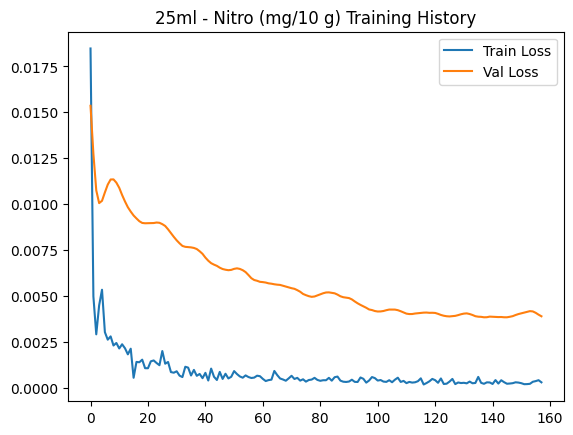


Training for 25ml - Posh Nitro (mg/10 g)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


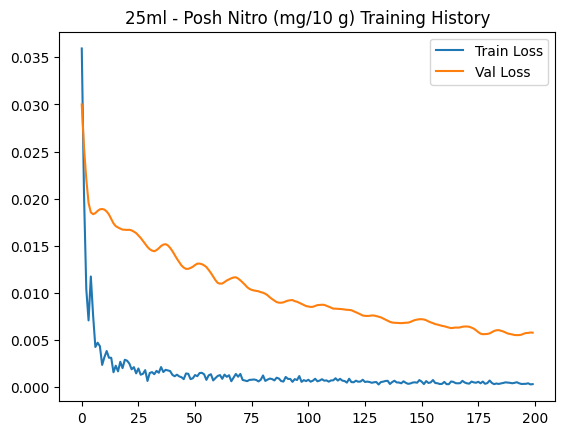


Training for 25ml - Pota Nitro (mg/10 g)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


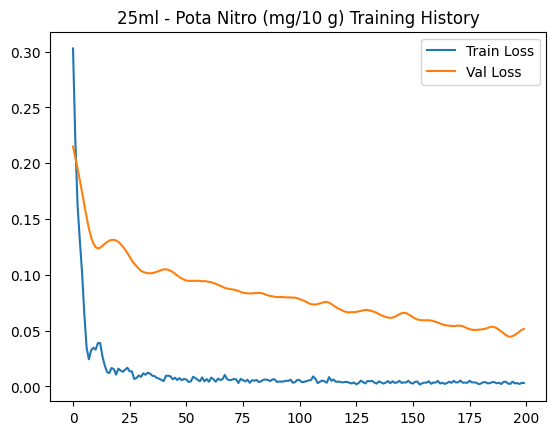


Training for 50ml - Ph


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


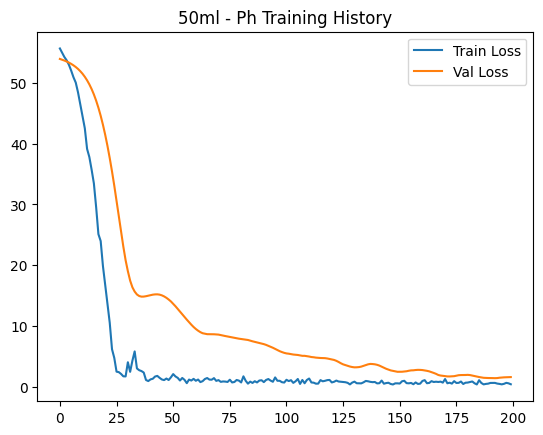


Training for 50ml - Nitro (mg/10 g)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


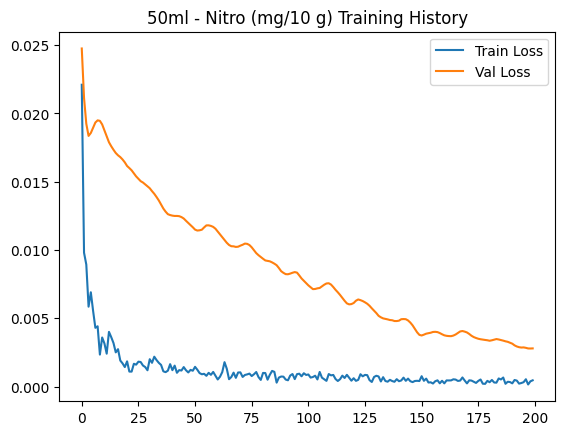


Training for 50ml - Posh Nitro (mg/10 g)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


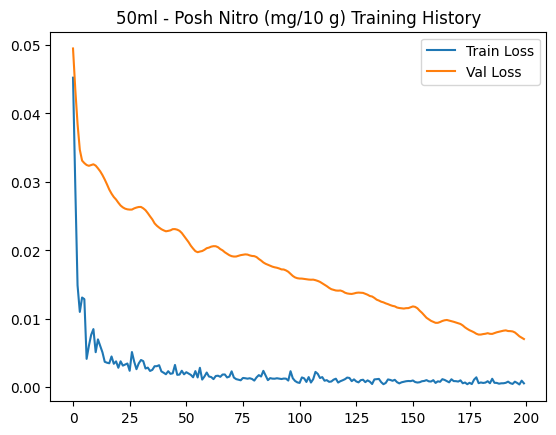


Training for 50ml - Pota Nitro (mg/10 g)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


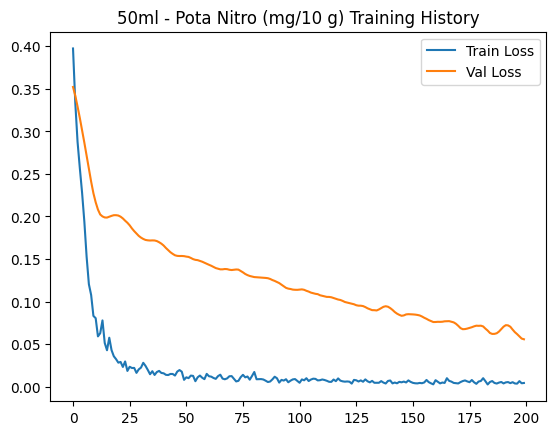

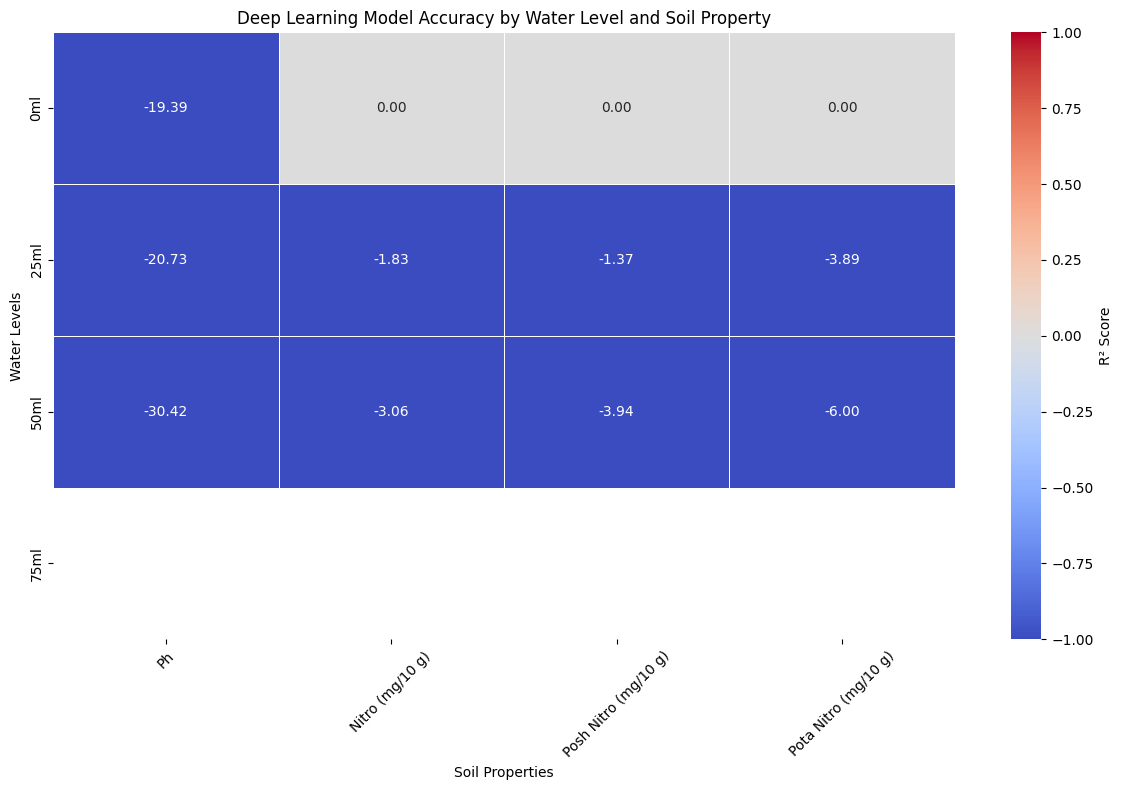


Performance Statistics:
Mean R² across all: nan

By Water Level:
0ml     -4.848306
25ml    -6.952684
50ml   -10.856097
75ml          NaN
dtype: object

By Soil Property:
Ph                     -23.516318
Nitro (mg/10 g)         -1.631112
Posh Nitro (mg/10 g)     -1.76801
Pota Nitro (mg/10 g)     -3.29401
dtype: object


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


InvalidParameterError: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <function <lambda> at 0x79ea683f7a60> instead.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
df = pd.read_csv('Usoildataset.csv').dropna()

# Enhanced water level extraction
def extract_water_level(record_group):
    if isinstance(record_group, str):
        if '_' in record_group:
            return record_group.split('_')[-1]
        elif '-' in record_group and 'ml' in record_group:
            return record_group.split('-')[-1]
    return np.nan

df['water_level'] = df['Records_Group'].apply(extract_water_level)
df = df.dropna(subset=['water_level'])

# Filter for target water levels
water_levels = ['0ml', '25ml', '50ml', '75ml']
df = df[df['water_level'].isin(water_levels)]

# Feature engineering
wavelengths = ['485', '510', '535', '760']
df['NDVI'] = (df['760'] - df['680']) / (df['760'] + df['680'])
df['SIR'] = df['760'] / df['680']
features = wavelengths + ['NDVI', 'SIR']
targets = ['Ph', 'Nitro (mg/10 g)', 'Posh Nitro (mg/10 g)', 'Pota Nitro (mg/10 g)']

# Create results matrix
results_matrix = pd.DataFrame(index=water_levels, columns=targets)

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.001

# DL Model Builder
def build_dl_model(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                 loss='mse',
                 metrics=['mae'])
    return model

# Train and evaluate for each water level and target
for level in water_levels:
    level_data = df[df['water_level'] == level]
    if len(level_data) < 10:  # Skip if insufficient samples
        continue

    X = level_data[features].values
    y = level_data[targets].values

    # Train-test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=pd.qcut(y[:,0], q=4)
    )

    # Scale features per water level
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape for DL (samples, timesteps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    for i, target in enumerate(targets):
        print(f"\nTraining for {level} - {target}")

        # Early stopping
        es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

        # Build and train model
        model = build_dl_model((X_train.shape[1], 1))
        history = model.fit(
            X_train, y_train[:,i],
            validation_split=0.2,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[es],
            verbose=0
        )

        # Evaluate
        y_pred = model.predict(X_test).flatten()
        r2 = r2_score(y_test[:,i], y_pred)
        results_matrix.loc[level, target] = r2

        # Plot training history
        plt.figure()
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{level} - {target} Training History')
        plt.legend()
        plt.show()

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(
    results_matrix.astype(float),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'R² Score'}
)
plt.title('Deep Learning Model Accuracy by Water Level and Soil Property')
plt.xlabel('Soil Properties')
plt.ylabel('Water Levels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical summary
print("\nPerformance Statistics:")
print("="*50)
print(f"Mean R² across all: {results_matrix.values.mean():.3f}")
print("\nBy Water Level:")
print(results_matrix.mean(axis=1))
print("\nBy Soil Property:")
print(results_matrix.mean(axis=0))

# Feature importance analysis (using permutation importance)
from sklearn.inspection import permutation_importance

# Example for one combination
sample_data = df[(df['water_level'] == '0ml')][features]
sample_target = df[(df['water_level'] == '0ml')]['Ph']
X_train, X_test, y_train, y_test = train_test_split(
    sample_data, sample_target, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = build_dl_model((X_train.shape[1], 1))
model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1),
          y_train, epochs=100, verbose=0)

result = permutation_importance(
    lambda x: model.predict(x.reshape(x.shape[0], x.shape[1], 1)).flatten(),
    X_test,
    y_test,
    n_repeats=10,
    random_state=42
)

plt.figure()
sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(features)[sorted_idx])
plt.title("Permutation Importance (0ml - pH)")
plt.tight_layout()
plt.show()

In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 577.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv('Usoildataset.csv').dropna()
df['water_level'] = df['Records_Group'].str.extract(r'(\d+ml)$')
df = df.dropna(subset=['water_level'])

# Configuration
WATER_LEVELS = ['0ml', '25ml', '50ml', '75ml']
FEATURES = ['485', '510', '535', '760', '680']
TARGETS = ['Ph', 'Nitro (mg/10 g)', 'Posh Nitro (mg/10 g)', 'Pota Nitro (mg/10 g)']

# Initialize results matrix
accuracy_matrix = pd.DataFrame(
    columns=pd.MultiIndex.from_product([TARGETS, ['R²', 'RMSE']]),
    index=WATER_LEVELS
)

# Deep Learning Model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(FEATURES),)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Evaluate each water level
for level in WATER_LEVELS:
    level_data = df[df['water_level'] == level]
    if len(level_data) < 10:
        continue

    X = level_data[FEATURES]
    y = level_data[TARGETS]

    # Split and scale
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train and evaluate for each target
    for target in TARGETS:
        model = build_model()
        early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

        model.fit(
            X_train, y_train[target],
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )

        y_pred = model.predict(X_test).flatten()
        accuracy_matrix.loc[level, (target, 'R²')] = r2_score(y_test[target], y_pred)
        accuracy_matrix.loc[level, (target, 'RMSE')] = np.sqrt(
            tf.keras.metrics.mean_squared_error(y_test[target], y_pred).numpy()
        )

# Format and display results
accuracy_matrix = accuracy_matrix.apply(pd.to_numeric)
print("\n" + "="*60)
print("Deep Learning Performance Matrix")
print("="*60)
print(accuracy_matrix.round(3))

# Visualize as styled matrix
styled_matrix = accuracy_matrix.style\
    .background_gradient(cmap='RdYlGn', vmin=-1, vmax=1, subset=pd.IndexSlice[:, (slice(None), 'R²')])\
    .background_gradient(cmap='YlOrRd_r', subset=pd.IndexSlice[:, (slice(None), 'RMSE')])\
    .set_caption("Water Level vs Soil Property Prediction Performance")

display(styled_matrix)

# Save visualization
plt.figure(figsize=(12, 6))
plt.axis('off')
plt.table(
    cellText=accuracy_matrix.round(3).values,
    rowLabels=accuracy_matrix.index,
    colLabels=accuracy_matrix.columns,
    cellLoc='center',
    loc='center'
)
plt.title("Deep Learning Performance Matrix", pad=20)
plt.tight_layout()
plt.savefig('performance_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


AttributeError: module 'keras._tf_keras.keras.metrics' has no attribute 'mean_squared_error'

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

def load_and_preprocess(filepath):
    """Load and preprocess data without excessive noise injection"""
    df = pd.read_csv(filepath)
    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])].copy()

    # Feature engineering
    if all(wl in df.columns for wl in ['680', '860']):
        df['NDVI'] = (df['860'] - df['680']) / (df['860'] + df['680'] + 1e-9)
    if all(wl in df.columns for wl in ['560', '680', '705']):
        df['MCARI'] = ((df['705'] - df['680']) - 0.2*(df['705']-df['560'])) * (df['705']/(df['680'] + 1e-9))

    # Add more spectral indices if available
    if all(wl in df.columns for wl in ['750', '705']):
        df['Red Edge'] = df['750'] / df['705']

    return df.dropna(subset=['Posh Nitro (mg/10 g)'])

def calculate_metrics(y_true, y_pred):
    """Calculate multiple metrics for better evaluation"""
    mae = mean_absolute_error(y_true, y_pred)

    # Handle division by zero in MAPE calculation
    y_true_non_zero = np.where(np.abs(y_true) < 0.001, 0.001, y_true)
    mape = mean_absolute_percentage_error(y_true_non_zero, y_pred) * 100

    r2 = r2_score(y_true, y_pred)
    pred_range = np.ptp(y_pred)
    true_range = np.ptp(y_true)

    return {
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Pred_Range': pred_range,
        'True_Range': true_range
    }

def train_evaluate_report(X_train, X_test, y_train, y_test, level):
    """Train model with regularization to prevent overfitting"""
    # Create a more robust model with regularization parameters
    model = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=100,           # Increased from 60
            max_depth=3,                # Reduced from 5
            min_samples_leaf=8,         # Increased from 5
            min_samples_split=5,        # Added parameter
            max_features='sqrt',        # Changed from 0.6
            bootstrap=True,             # Ensure bootstrap sampling
            oob_score=True,             # Use out-of-bag scoring
            random_state=42
        )
    )

    # Perform cross-validation on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    # Fit the model
    model.fit(X_train, y_train)

    # Get feature importances
    rf_model = model.named_steps['randomforestregressor']
    feature_importance = rf_model.feature_importances_

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)

    # Print diagnostic information
    print(f"\n{level} Model Diagnostics:")
    print(f"Training metrics:")
    for metric, value in train_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"\nTest metrics:")
    for metric, value in test_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"Range comparison:")
    print(f"- Actual range (train): {train_metrics['True_Range']:.3f}")
    print(f"- Predicted range (train): {train_metrics['Pred_Range']:.3f}")
    print(f"- Actual range (test): {test_metrics['True_Range']:.3f}")
    print(f"- Predicted range (test): {test_metrics['Pred_Range']:.3f}")

    print(f"Cross-validation MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"OOB Score: {rf_model.oob_score_:.3f}")

    return test_metrics

def main():
    df = load_and_preprocess('/content/merged_soildataset_updated.csv')

    # Expand features if available
    base_features = ['NDVI', 'MCARI']
    extended_features = base_features.copy()
    if 'Red Edge' in df.columns:
        extended_features.append('Red Edge')

    # Try to find additional wavelength columns
    wavelength_cols = [col for col in df.columns if col.isdigit()]
    if len(wavelength_cols) > 0:
        print(f"Found {len(wavelength_cols)} spectral bands available")
        # Optionally use PCA or feature selection here

    # Final feature set
    features = extended_features
    print(f"Using features: {features}")

    results = {}

    for level in ['0ml', '25ml', '50ml']:
        level_data = df[df['water_level'] == level]
        if len(level_data) < 51:
            print(f"\nCannot process {level} - only {len(level_data)} samples available (needs 51)")
            continue

        print(f"\n{'='*30} {level} {'='*30}")

        # Check for outliers
        target = 'Posh Nitro (mg/10 g)'
        Q1 = level_data[target].quantile(0.25)
        Q3 = level_data[target].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = level_data[(level_data[target] < lower_bound) | (level_data[target] > upper_bound)]
        if len(outliers) > 0:
            print(f"Found {len(outliers)} potential outliers in {level} data")
            # Option: Remove outliers or winsorize

        X = level_data[features].values
        y = level_data['Posh Nitro (mg/10 g)'].values

        # Stratified split based on target value ranges
        y_bins = pd.qcut(y, q=4, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=40,
            test_size=11,
            random_state=42,
            stratify=y_bins
        )

        # Train and evaluate
        metrics = train_evaluate_report(X_train, X_test, y_train, y_test, level)
        results[level] = metrics

    # Final results
    print("\n\nFinal Results Summary (40 train / 11 test):")
    print("="*60)
    print(f"{'Water Level':<10} | {'MAE':<10} | {'R2':<10} | {'Range Match':<15}")
    print("-"*60)
    for level, metrics in results.items():
        range_match = metrics['Pred_Range'] / metrics['True_Range'] * 100
        print(f"{level:<10} | {metrics['MAE']:.3f}      | {metrics['R2']:.3f}      | {range_match:.1f}%")

if __name__ == "__main__":
    main()

Found 18 spectral bands available
Using features: ['NDVI', 'MCARI']

============================== 0ml ==============================
Found 3 potential outliers in 0ml data

0ml Model Diagnostics:
Training metrics:
- MAE: 0.012
- MAPE: 452.070
- R2: 0.063

Test metrics:
- MAE: 0.007
- MAPE: 514.090
- R2: -1.109
Range comparison:
- Actual range (train): 0.256
- Predicted range (train): 0.015
- Actual range (test): 0.021
- Predicted range (test): 0.014
Cross-validation MAE: 0.013 (±0.010)
OOB Score: -0.059

============================== 25ml ==============================
Found 1 potential outliers in 25ml data

25ml Model Diagnostics:
Training metrics:
- MAE: 0.026
- MAPE: 455.919
- R2: 0.064

Test metrics:
- MAE: 0.023
- MAPE: 13.809
- R2: -0.027
Range comparison:
- Actual range (train): 0.258
- Predicted range (train): 0.017
- Actual range (test): 0.070
- Predicted range (test): 0.009
Cross-validation MAE: 0.028 (±0.009)
OOB Score: -0.107

============================== 50ml =======

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

def load_and_preprocess(filepath):
    """Load and preprocess data while ensuring valid spectral indices."""
    df = pd.read_csv(filepath)
    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])].copy()

    # Compute Spectral Indices
    if {'680', '860'}.issubset(df.columns):
        df['NDVI'] = (df['860'] - df['680']) / (df['860'] + df['680'] + 1e-9)
    if {'560', '680', '705'}.issubset(df.columns):
        df['MCARI'] = ((df['705'] - df['680']) - 0.2*(df['705']-df['560'])) * (df['705']/(df['680'] + 1e-9))
    if {'750', '705'}.issubset(df.columns):
        df['Red Edge'] = df['750'] / df['705']

    return df.dropna(subset=['Posh Nitro (mg/10 g)'])

def select_important_wavelengths(df, target):
    """Identify the most relevant wavelengths affecting nitrogen content."""
    wavelength_cols = [col for col in df.columns if col.isdigit()]
    X = df[wavelength_cols].values
    y = df[target].values

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=wavelength_cols)
    important_features = feature_importances.nlargest(5).index.tolist()

    return important_features

def calculate_metrics(y_true, y_pred):
    """Calculate performance metrics for evaluation."""
    mae = mean_absolute_error(y_true, y_pred)
    y_true_non_zero = np.where(np.abs(y_true) < 0.001, 0.001, y_true)
    mape = mean_absolute_percentage_error(y_true_non_zero, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    pred_range = np.ptp(y_pred)
    true_range = np.ptp(y_true)

    return {'MAE': mae, 'MAPE': mape, 'R2': r2, 'Pred_Range': pred_range, 'True_Range': true_range}

def train_evaluate_report(X_train, X_test, y_train, y_test, level, features):
    """Train RandomForest model and evaluate its performance."""
    model = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=100, max_depth=3, min_samples_leaf=8, min_samples_split=5,
            max_features='sqrt', bootstrap=True, oob_score=True, random_state=42
        )
    )

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    model.fit(X_train, y_train)
    rf_model = model.named_steps['randomforestregressor']

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)

    print(f"\n{level} Model Diagnostics:")
    print(f"Using Wavelengths: {features}")
    print(f"Training metrics:")
    for metric, value in train_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"\nTest metrics:")
    for metric, value in test_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"Cross-validation MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"OOB Score: {rf_model.oob_score_:.3f}")

    return test_metrics

def main():
    df = load_and_preprocess('/content/merged_soildataset_updated.csv')

    important_wavelengths = select_important_wavelengths(df, 'Posh Nitro (mg/10 g)')
    features = ['NDVI', 'MCARI'] + important_wavelengths
    print(f"Using selected features: {features}")

    results = {}

    for level in ['0ml', '25ml', '50ml']:
        level_data = df[df['water_level'] == level]
        if len(level_data) < 51:
            print(f"\nCannot process {level} - only {len(level_data)} samples available (needs 51)")
            continue

        print(f"\n{'='*30} {level} {'='*30}")

        target = 'Posh Nitro (mg/10 g)'
        X = level_data[features].values
        y = level_data[target].values

        y_bins = pd.qcut(y, q=4, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=40, test_size=11, random_state=42, stratify=y_bins
        )

        metrics = train_evaluate_report(X_train, X_test, y_train, y_test, level, features)
        results[level] = metrics

    print("\n\nFinal Results Summary (40 train / 11 test):")
    print("="*60)
    print(f"{'Water Level':<10} | {'MAE':<10} | {'R2':<10} | {'Range Match':<15}")
    print("-"*60)
    for level, metrics in results.items():
        range_match = metrics['Pred_Range'] / metrics['True_Range'] * 100
        print(f"{level:<10} | {metrics['MAE']:.3f}      | {metrics['R2']:.3f}      | {range_match:.1f}%")

if __name__ == "__main__":
    main()


Using selected features: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']

============================== 0ml ==============================

0ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.011
- MAPE: 488.994
- R2: 0.079

Test metrics:
- MAE: 0.005
- MAPE: 463.660
- R2: -0.967
Cross-validation MAE: 0.013 (±0.010)
OOB Score: -0.055

============================== 25ml ==============================

25ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.025
- MAPE: 460.269
- R2: 0.088

Test metrics:
- MAE: 0.024
- MAPE: 14.044
- R2: -0.058
Cross-validation MAE: 0.028 (±0.009)
OOB Score: -0.162

============================== 50ml ==============================

50ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.029
- MAPE: 594.732
- R2: 0.175

Test metrics:
- MAE: 0.024
-

Using selected features: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']


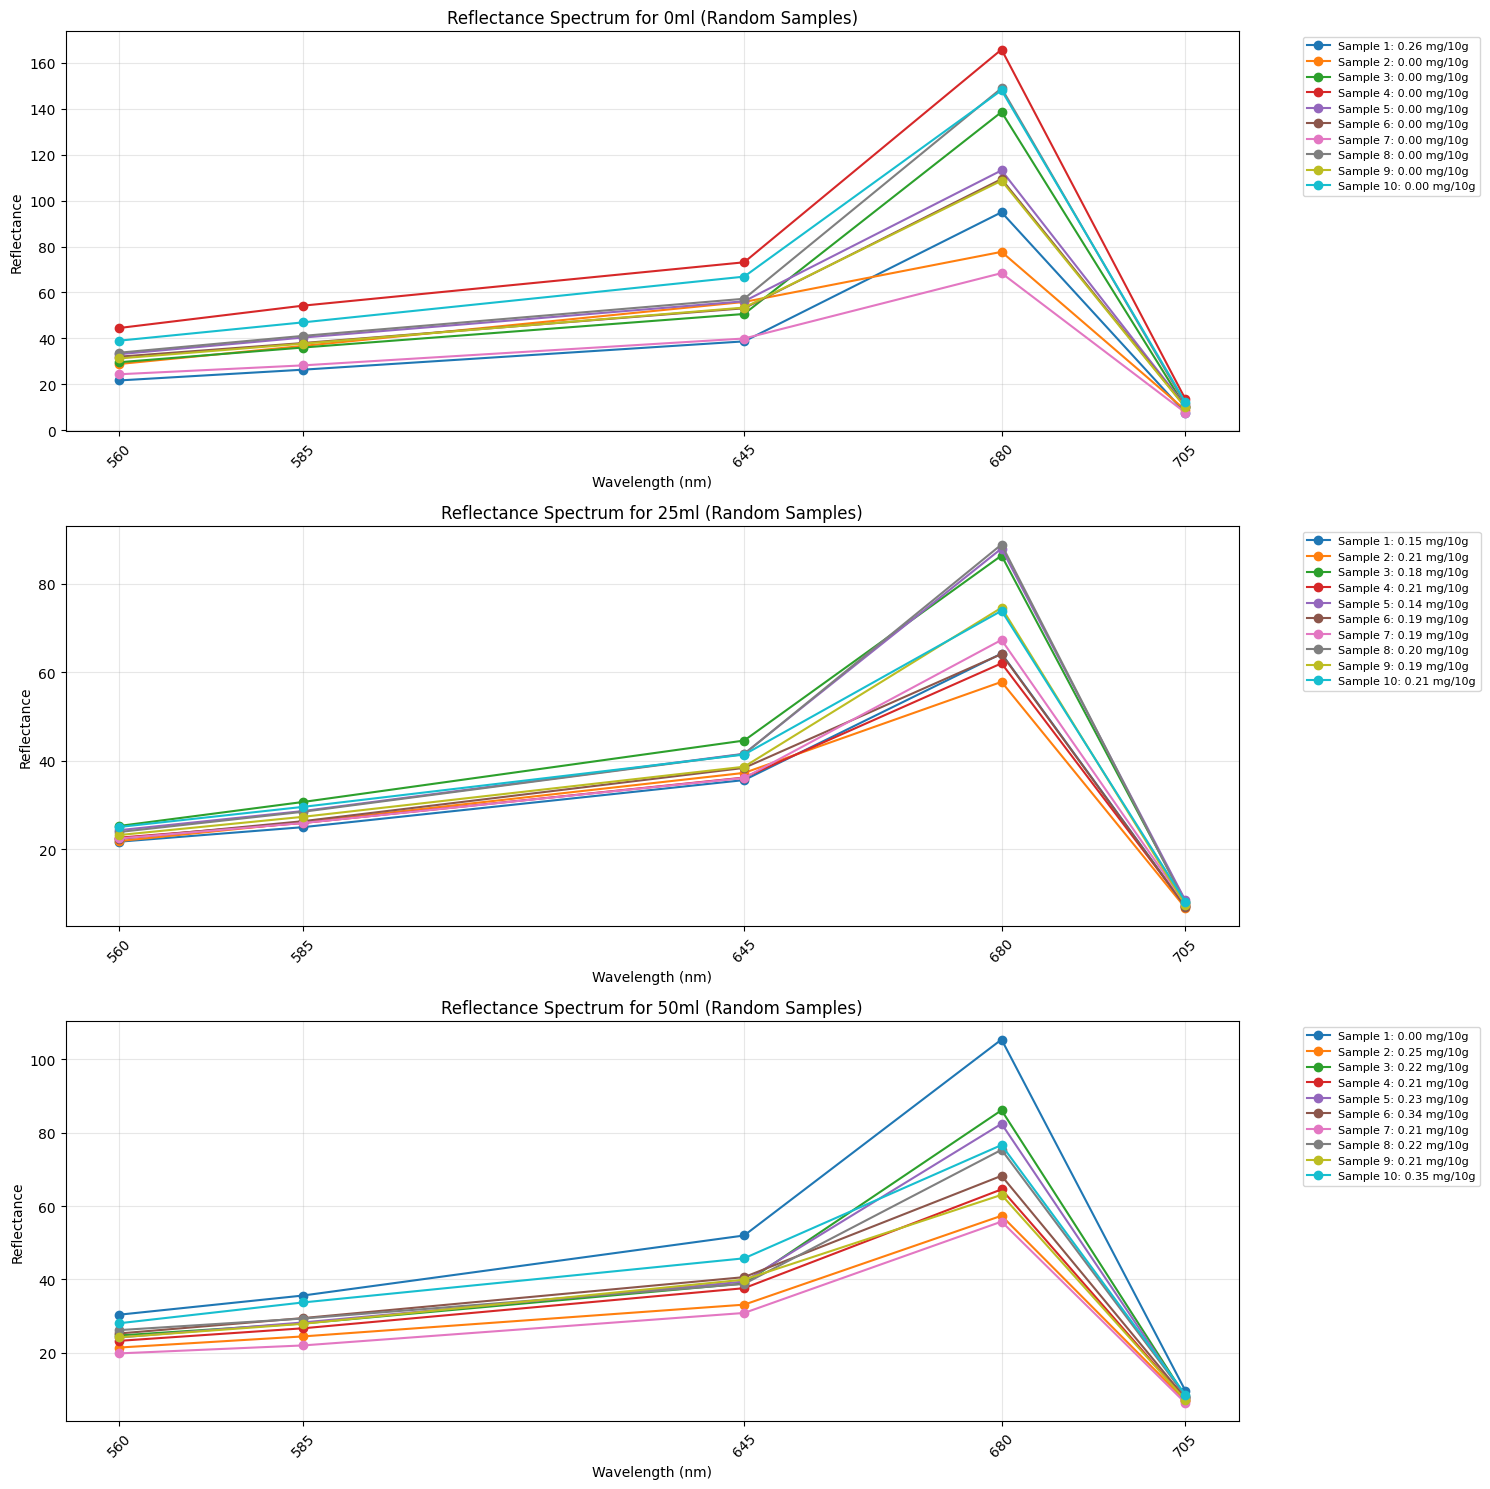


============================== 0ml ==============================

0ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.008
- MAPE: 364.295
- R2: 0.079

Test metrics:
- MAE: 0.004
- MAPE: 348.097
- R2: -1.110
Cross-validation MAE: 0.009 (±0.007)
OOB Score: -0.055

============================== 25ml ==============================

25ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.018
- MAPE: 333.793
- R2: 0.095

Test metrics:
- MAE: 0.018
- MAPE: 15.117
- R2: -0.077
Cross-validation MAE: 0.019 (±0.007)
OOB Score: -0.168

============================== 50ml ==============================

50ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.021
- MAPE: 411.409
- R2: 0.218

Test metrics:
- MAE: 0.018
- MAPE: 9.557
- R2: 0.139
Cross-validation MAE: 0.025 (±0.008)
OOB Score: -0.05

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

def load_and_preprocess(filepath):
    """Load and preprocess data while ensuring valid spectral indices."""
    df = pd.read_csv(filepath)
    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])].copy()

    # Compute Spectral Indices
    if {'680', '860'}.issubset(df.columns):
        df['NDVI'] = (df['860'] - df['680']) / (df['860'] + df['680'] + 1e-9)
    if {'560', '680', '705'}.issubset(df.columns):
        df['MCARI'] = ((df['705'] - df['680']) - 0.2*(df['705']-df['560'])) * (df['705']/(df['680'] + 1e-9))
    if {'750', '705'}.issubset(df.columns):
        df['Red Edge'] = df['750'] / df['705']

    return df.dropna(subset=['Posh Nitro (mg/10 g)'])

def select_important_wavelengths(df, target):
    """Identify the most relevant wavelengths affecting nitrogen content."""
    wavelength_cols = [col for col in df.columns if col.isdigit()]
    X = df[wavelength_cols].values
    y = df[target].values

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=wavelength_cols)
    important_features = feature_importances.nlargest(5).index.tolist()

    return important_features

def calculate_metrics(y_true, y_pred):
    """Calculate performance metrics for evaluation."""
    mae = mean_absolute_error(y_true, y_pred)
    y_true_non_zero = np.where(np.abs(y_true) < 0.001, 0.001, y_true)
    mape = mean_absolute_percentage_error(y_true_non_zero, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    pred_range = np.ptp(y_pred)
    true_range = np.ptp(y_true)

    return {'MAE': mae, 'MAPE': mape, 'R2': r2, 'Pred_Range': pred_range, 'True_Range': true_range}

def train_evaluate_report(X_train, X_test, y_train, y_test, level, features):
    """Train RandomForest model and evaluate its performance."""
    model = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=100, max_depth=3, min_samples_leaf=8, min_samples_split=5,
            max_features='sqrt', bootstrap=True, oob_score=True, random_state=42
        )
    )

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    model.fit(X_train, y_train)
    rf_model = model.named_steps['randomforestregressor']

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)

    print(f"\n{level} Model Diagnostics:")
    print(f"Using Wavelengths: {features}")
    print(f"Training metrics:")
    for metric, value in train_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"\nTest metrics:")
    for metric, value in test_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"Cross-validation MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"OOB Score: {rf_model.oob_score_:.3f}")

    return test_metrics

def plot_nitro_vs_wavelengths(df, important_wavelengths, water_levels=['0ml', '25ml', '50ml'], n_samples=10):
    """Plot random nitro samples against important wavelengths for each water level."""
    plt.figure(figsize=(15, 15))

    for i, level in enumerate(water_levels, 1):
        level_data = df[df['water_level'] == level]
        if len(level_data) == 0:
            continue

        # Get random samples (ensure we don't take more than available)
        samples = level_data.sample(n=min(n_samples, len(level_data)), random_state=42)

        plt.subplot(3, 1, i)

        # Convert wavelengths to numeric and sort them
        wavelengths = sorted([float(wl) for wl in important_wavelengths])
        str_wavelengths = [str(int(wl)) for wl in wavelengths]  # Convert back to string for DataFrame access

        # Plot each sample
        for idx, (_, row) in enumerate(samples.iterrows()):
            nitro_value = row['Posh Nitro (mg/10 g)']
            reflectance = [row[wl] for wl in str_wavelengths]

            plt.plot(wavelengths, reflectance,
                     marker='o', linestyle='-',
                     label=f'Sample {idx+1}: {nitro_value:.2f} mg/10g')

        plt.title(f'Reflectance Spectrum for {level} (Random Samples)', fontsize=12)
        plt.xlabel('Wavelength (nm)', fontsize=10)
        plt.ylabel('Reflectance', fontsize=10)
        plt.xticks(wavelengths, rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

def main():
    df = load_and_preprocess('/content/merged_soildataset_updated.csv')

    important_wavelengths = select_important_wavelengths(df, 'Posh Nitro (mg/10 g)')
    features = ['NDVI', 'MCARI'] + important_wavelengths
    print(f"Using selected features: {features}")

    # Plot the reflectance vs wavelength for random samples
    plot_nitro_vs_wavelengths(df, important_wavelengths)

    results = {}

    for level in ['0ml', '25ml', '50ml']:
        level_data = df[df['water_level'] == level]
        if len(level_data) < 51:
            print(f"\nCannot process {level} - only {len(level_data)} samples available (needs 51)")
            continue

        print(f"\n{'='*30} {level} {'='*30}")

        target = 'Nitro (mg/10 g)'
        X = level_data[features].values
        y = level_data[target].values

        y_bins = pd.qcut(y, q=4, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=40, test_size=11, random_state=42, stratify=y_bins
        )

        metrics = train_evaluate_report(X_train, X_test, y_train, y_test, level, features)
        results[level] = metrics

    print("\n\nFinal Results Summary (40 train / 11 test):")
    print("="*60)
    print(f"{'Water Level':<10} | {'MAE':<10} | {'R2':<10} | {'Range Match':<15}")
    print("-"*60)
    for level, metrics in results.items():
        range_match = metrics['Pred_Range'] / metrics['True_Range'] * 100
        print(f"{level:<10} | {metrics['MAE']:.3f}      | {metrics['R2']:.3f}      | {range_match:.1f}%")

if __name__ == "__main__":
    main()

Using selected features: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']


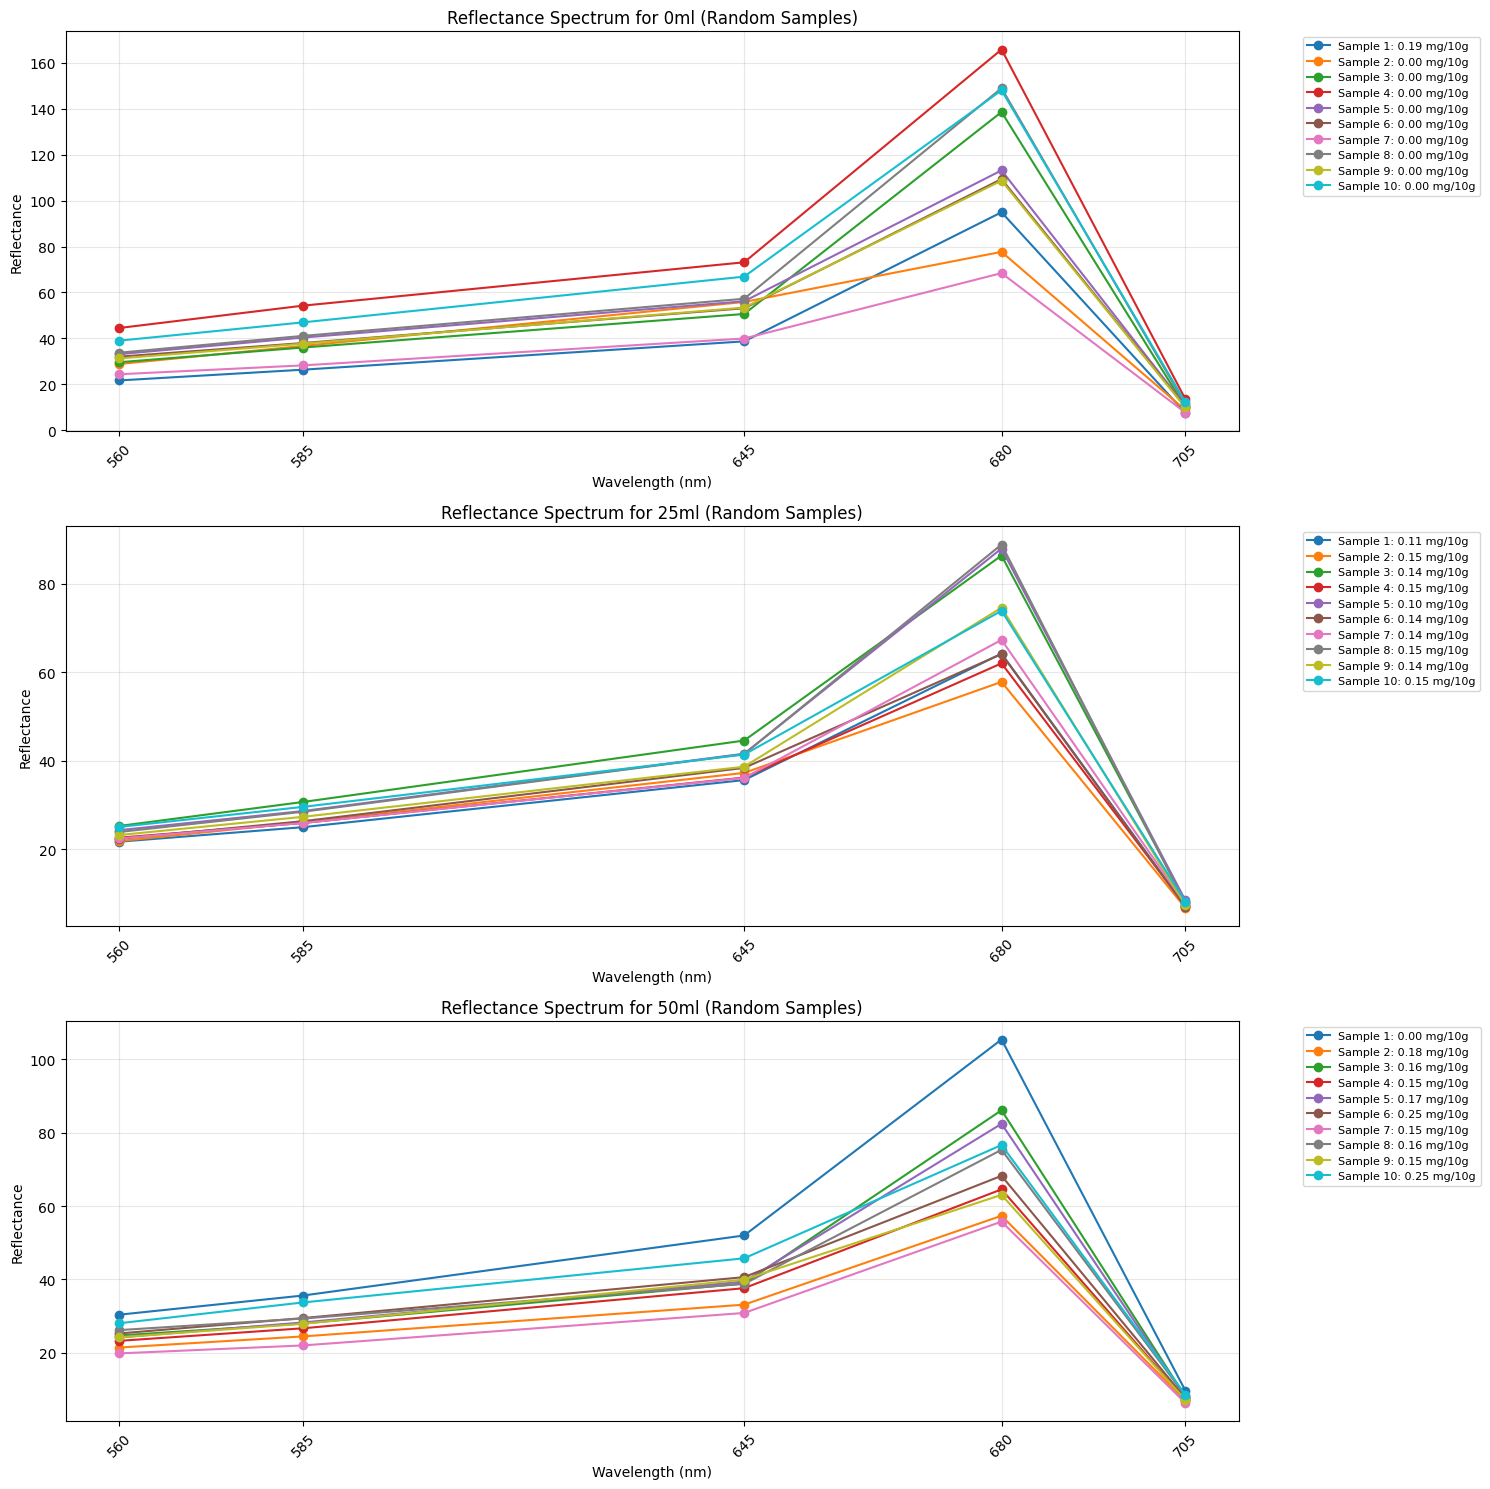


============================== 0ml ==============================

0ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.008
- MAPE: 364.295
- R2: 0.079

Test metrics:
- MAE: 0.004
- MAPE: 348.097
- R2: -1.110
Cross-validation MAE: 0.009 (±0.007)
OOB Score: -0.055

============================== 25ml ==============================

25ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.018
- MAPE: 333.793
- R2: 0.095

Test metrics:
- MAE: 0.018
- MAPE: 15.117
- R2: -0.077
Cross-validation MAE: 0.019 (±0.007)
OOB Score: -0.168

============================== 50ml ==============================

50ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.021
- MAPE: 411.409
- R2: 0.218

Test metrics:
- MAE: 0.018
- MAPE: 9.557
- R2: 0.139
Cross-validation MAE: 0.025 (±0.008)
OOB Score: -0.05

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

def load_and_preprocess(filepath):
    """Load and preprocess data while ensuring valid spectral indices."""
    df = pd.read_csv(filepath)
    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])].copy()

    # Compute Spectral Indices
    if {'680', '860'}.issubset(df.columns):
        df['NDVI'] = (df['860'] - df['680']) / (df['860'] + df['680'] + 1e-9)
    if {'560', '680', '705'}.issubset(df.columns):
        df['MCARI'] = ((df['705'] - df['680']) - 0.2*(df['705']-df['560'])) * (df['705']/(df['680'] + 1e-9))
    if {'750', '705'}.issubset(df.columns):
        df['Red Edge'] = df['750'] / df['705']

    return df.dropna(subset=['Posh Nitro (mg/10 g)'])

def select_important_wavelengths(df, target):
    """Identify the most relevant wavelengths affecting nitrogen content."""
    wavelength_cols = [col for col in df.columns if col.isdigit()]
    X = df[wavelength_cols].values
    y = df[target].values

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=wavelength_cols)
    important_features = feature_importances.nlargest(5).index.tolist()

    return important_features

def calculate_metrics(y_true, y_pred):
    """Calculate performance metrics for evaluation."""
    mae = mean_absolute_error(y_true, y_pred)
    y_true_non_zero = np.where(np.abs(y_true) < 0.001, 0.001, y_true)
    mape = mean_absolute_percentage_error(y_true_non_zero, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    pred_range = np.ptp(y_pred)
    true_range = np.ptp(y_true)

    return {'MAE': mae, 'MAPE': mape, 'R2': r2, 'Pred_Range': pred_range, 'True_Range': true_range}

def train_evaluate_report(X_train, X_test, y_train, y_test, level, features):
    """Train RandomForest model and evaluate its performance."""
    model = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=100, max_depth=3, min_samples_leaf=8, min_samples_split=5,
            max_features='sqrt', bootstrap=True, oob_score=True, random_state=42
        )
    )

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    model.fit(X_train, y_train)
    rf_model = model.named_steps['randomforestregressor']

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)

    print(f"\n{level} Model Diagnostics:")
    print(f"Using Wavelengths: {features}")
    print(f"Training metrics:")
    for metric, value in train_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"\nTest metrics:")
    for metric, value in test_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"Cross-validation MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"OOB Score: {rf_model.oob_score_:.3f}")

    return test_metrics

def plot_nitro_vs_wavelengths(df, important_wavelengths, water_levels=['0ml', '25ml', '50ml'], n_samples=10):
    """Plot random nitro samples against important wavelengths for each water level."""
    plt.figure(figsize=(15, 15))

    for i, level in enumerate(water_levels, 1):
        level_data = df[df['water_level'] == level]
        if len(level_data) == 0:
            continue

        # Get random samples (ensure we don't take more than available)
        samples = level_data.sample(n=min(n_samples, len(level_data)), random_state=42)

        plt.subplot(3, 1, i)

        # Convert wavelengths to numeric and sort them
        wavelengths = sorted([float(wl) for wl in important_wavelengths])
        str_wavelengths = [str(int(wl)) for wl in wavelengths]  # Convert back to string for DataFrame access

        # Plot each sample
        for idx, (_, row) in enumerate(samples.iterrows()):
            nitro_value = row['Nitro (mg/10 g)']
            reflectance = [row[wl] for wl in str_wavelengths]

            plt.plot(wavelengths, reflectance,
                     marker='o', linestyle='-',
                     label=f'Sample {idx+1}: {nitro_value:.2f} mg/10g')

        plt.title(f'Reflectance Spectrum for {level} (Random Samples)', fontsize=12)
        plt.xlabel('Wavelength (nm)', fontsize=10)
        plt.ylabel('Reflectance', fontsize=10)
        plt.xticks(wavelengths, rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

def main():
    df = load_and_preprocess('/content/merged_soildataset_updated.csv')

    important_wavelengths = select_important_wavelengths(df, 'Posh Nitro (mg/10 g)')
    features = ['NDVI', 'MCARI'] + important_wavelengths
    print(f"Using selected features: {features}")

    # Plot the reflectance vs wavelength for random samples
    plot_nitro_vs_wavelengths(df, important_wavelengths)

    results = {}

    for level in ['0ml', '25ml', '50ml']:
        level_data = df[df['water_level'] == level]
        if len(level_data) < 51:
            print(f"\nCannot process {level} - only {len(level_data)} samples available (needs 51)")
            continue

        print(f"\n{'='*30} {level} {'='*30}")

        target = 'Nitro (mg/10 g)'
        X = level_data[features].values
        y = level_data[target].values

        y_bins = pd.qcut(y, q=4, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=40, test_size=11, random_state=42, stratify=y_bins
        )

        metrics = train_evaluate_report(X_train, X_test, y_train, y_test, level, features)
        results[level] = metrics

    print("\n\nFinal Results Summary (40 train / 11 test):")
    print("="*60)
    print(f"{'Water Level':<10} | {'MAE':<10} | {'R2':<10} | {'Range Match':<15}")
    print("-"*60)
    for level, metrics in results.items():
        range_match = metrics['Pred_Range'] / metrics['True_Range'] * 100
        print(f"{level:<10} | {metrics['MAE']:.3f}      | {metrics['R2']:.3f}      | {range_match:.1f}%")

if __name__ == "__main__":
    main()